# Coolstore Evaluation

In this notebook, we evaluate the value proposition of Kai. Kai uses additional data from Konveyor Hub (solved examples), static code analysis as well as the rules themselves to augment an LLM prompt to get better quality responses. This is in contrast to using an LLM directly with little or no specific information in the prompts.

We will work with Kai to provide fixes for issues identified in [Coolstore](https://github.com/konveyor-ecosystem/coolstore) app for different kinds of issues. The fixes for these issues involve varying levels of complexity. For each issue, we try to evaluate the responses under two conditions - with and without supplemental information from the analysis. In the supplemental analysis information, we will permute between text description about issues, previous solved examples, static code analysis information, etc.

Finally, we will compare how well Kai does compared to zero-shot prompts.

For evaluating the responses, we will be using another LLM to evaluate based on a well defined criteria. More about details of evaluation later.

> Most of this notebook contains the actual experiments and steps to recreate them. Jump to the last section for results, learnings and conclusions.

## Pre-requisites

To run snippets in this notebook, you first need to set up Kai's virtualenv in the [base dir](../../).

Activate the virtualenv and install the Jupyter kernel for it:

```sh
python -m ipykernel install --user --name=<your-venv-dir>
```

We also need an additional package for plotting charts which we will install in our environment:

```sh
pip install matplotlib
```

Once installed, you should be able to use your Kai venv for this notebook. In VsCode, this can be done in the upper right corner. 

Then, create a `.env` file in the [base dir](../../) that contains export commands to source your LLM access keys:

```sh
export GENAI_KEY=<your-ibm-key>
export OPENAI_API_KEY=<your-openai-key>
```

We use IBM and OpenAI models in our experiments by default. However, you can configure which models to use further ahead when we create config files for the models. In that case, you can skip the keys for models you don't need. 

To configure which models to use to generate fixes, update the `KAI_FIX_MODELS` list in the following cell:

In [1]:
# some shorthands we can use in our experiments for different models
META_LLAMA_13b = 'meta-llama-13b'
META_LLAMA_70b = 'meta-llama-70b'
MIXTRAL = 'mixtral'
IBM_GRANITE = 'ibm-granite'
GPT_4 = "gpt-4"
GPT_3 = "gpt-3"
CLAUDE_SONNET = "sonnet-3-5"

# models used to generate kai-fix
KAI_FIX_MODELS = [
    META_LLAMA_13b,
    META_LLAMA_70b,
    IBM_GRANITE,
    MIXTRAL,
    GPT_3,
    GPT_4,
]

We use Claude Sonnet provided via AWS Bedrock for evaluation. You can choose to use GPT instead. When using Bedrock, make sure you have AWS credentials in your default aws profile. Update the `EVALUATION_MODEL` variable in the following cell to `GPT_4` to use gpt.

In [2]:
EVALUATION_MODEL = CLAUDE_SONNET

Run the following cell to load your `.env` file in notebook env.

In [3]:
%load_ext dotenv
%dotenv

Now, we will parse the analysis output to load the data into memory we need for the experiments. Continue running the cells in sequence one-by-one to advance.

In [4]:
# first we load incidents into memory and group by files for better access

import sys
sys.path.append('../../../kai')
from kai.models.report import Report

output_file = './analysis_output.yaml'
report = Report.load_report_from_file(output_file)
files = report.get_impacted_files()

# we filter out filepaths for dependencies
to_delete = []
for k in files: 
    if k.startswith('root/.m2'): to_delete.append(k)
for d in to_delete: del(files[d])

# printing file names and incidents in each file
for f in files: print(len(files[f]), f)

1 src/main/webapp/WEB-INF/web.xml
12 pom.xml
10 src/main/java/com/redhat/coolstore/model/Order.java
6 src/main/java/com/redhat/coolstore/model/OrderItem.java
5 src/main/webapp/WEB-INF/beans.xml
8 src/main/resources/META-INF/persistence.xml
6 src/main/java/com/redhat/coolstore/model/InventoryEntity.java
1 src/main/java/com/redhat/coolstore/model/ShoppingCart.java
6 src/main/java/com/redhat/coolstore/persistence/Resources.java
9 src/main/java/com/redhat/coolstore/rest/CartEndpoint.java
8 src/main/java/com/redhat/coolstore/rest/OrderEndpoint.java
3 src/main/java/com/redhat/coolstore/rest/ProductEndpoint.java
4 src/main/java/com/redhat/coolstore/rest/RestApplication.java
8 src/main/java/com/redhat/coolstore/service/CatalogService.java
2 src/main/java/com/redhat/coolstore/service/InventoryNotificationMDB.java
8 src/main/java/com/redhat/coolstore/service/OrderService.java
15 src/main/java/com/redhat/coolstore/service/OrderServiceMDB.java
3 src/main/java/com/redhat/coolstore/service/ProductSe

From the files displayed above, we will be focusing on following files in our experiments:

* src/main/java/com/redhat/coolstore/model/ShoppingCart.java (1 issue)
* src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java (10 issues)

Both of these files appear in our demo example found [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md)

The difficulty levels involved in fixing these files are different.

* Easy example [ShoppingCart.java](https://github.com/konveyor-ecosystem/coolstore/blob/main/src/main/java/com/redhat/coolstore/model/ShoppingCart.java)
  * This file only has 1 migration issue. And it can be fixed by changing one import to a Quarkus compatible import. The underlying API itself doesn't require any change.
* Hard example [ShoppingCartOrderProcessor.java](https://github.com/konveyor-ecosystem/coolstore/blob/main/src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java)
  * This file has 10 issues most of which involve replacing import statements from `javax` to `jakarta`.
  * However, we will focus on one issue that involves replacing JMS Topic with an Emitter. This is a code rewrite thats more than just doing a string replace.

Now, we will clone the example app. The following cell will create a `data` directory to contain all the data we will generate when running experiments.

In [5]:
# now we will get our test data
import os
import errno
from git import Repo
import importlib

def ensure_dirs(dir):
    try:
        os.makedirs(dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def clone_coolstore(branch: str, path: str):
    try:
        Repo.clone_from("https://github.com/konveyor-ecosystem/coolstore", 
            depth=1, single_branch=True, branch=branch, to_path=path)
    except Exception as e:
        if "already exists" not in str(e):
            print("fatal error cloning repo")
            sys.exit(1)

ensure_dirs("./data/apps/coolstore/")
clone_coolstore("quarkus", "./data/apps/coolstore/quarkus")
clone_coolstore("main", "./data/apps/coolstore/javaee")

Next, we will compile our analysis data as well as source code of affected files into a data structure for accessing later. We will also load the 3 examples we discussed earlier into variables so we can access them later.

In [6]:
# now we will create data required for evaluation
import copy
from datetime import datetime
from kai.evaluation import BenchmarkExample, evaluate
from kai.service.incident_store import Application

examples = {}
for f in files:
    original_content = ""
    expected_content = ""
    with open(f"./data/apps/coolstore/javaee/{f}", "r") as fl: original_content = fl.read()
    if os.path.exists(f"./data/apps/coolstore/quarkus/{f}"): 
        with open(f"./data/apps/coolstore/quarkus/{f}", "r") as fl: expected_content = fl.read()
    examples[f] = BenchmarkExample(
        application=Application(
            application_name="coolstore",
            current_branch="main",
            repo_uri_local="./data/apps/coolstore/javaee",
            generated_at=datetime.strptime("24/05/09 19:32:00", "%y/%m/%d %H:%M:%S"),
            repo_uri_origin="https://github.com/konveyor-ecosystem/coolstore",
            current_commit="aa"
        ),
        expected_file=expected_content,
        incidents=files[f],
        original_file=original_content,
        name=os.path.basename(f),
        report=report,
    )

EXAMPLE_EASY = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']
hard_example = examples['src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java']
ex = copy.deepcopy(hard_example)
ex.incidents = ex.incidents[:7]
EXAMPLE_HARD = copy.deepcopy(ex)

We will create some config files (in-memory) which we need to run Kai.

In [9]:
from jinja2 import Template

CONFIG_BASE_PATH = "./data/configs/"
OUTPUT_BASE_PATH = "./data/outputs/"

ensure_dirs(CONFIG_BASE_PATH)
ensure_dirs(OUTPUT_BASE_PATH)

templ = Template("""
trace_enabled = true
demo_mode = false
log_dir = "$pwd/logs"
file_log_level = "debug"
log_level = "info"

solution_consumers = {{ solution_consumers | default(["diff_only"]) }}

[models]
provider = "{{ model_provider }}"
template = "{{ prompt_template }}"

[models.args]
{% if model_provider == "ChatOpenAI" %}
model = "{{ model_id }}"
{% else %}
model_id = "{{ model_id }}"
{% endif %}
{% if max_tokens != "" %}
parameters.max_new_tokens = "{{ max_tokens }}"
{% endif %}

[incident_store]
solution_detectors = "naive"
solution_producers = {{ solution_producers | default("text_only") }}

[incident_store.args]
provider = "postgresql"
host = "127.0.0.1"
database = "kai"
user = "kai"
password = "dog8code"
""")

# model_provider: { model_id: {parameter: val}}
models = {
    "ChatIBMGenAI": {
        "meta-llama/llama-3-70b-instruct": {"max_tokens": "2048", "key": META_LLAMA_70b},
        "meta-llama/llama-2-13b-chat": {"max_tokens": "1536", "key": META_LLAMA_13b},
        "mistralai/mixtral-8x7b-instruct-v01": {"key": MIXTRAL},
        "ibm/granite-13b-chat-v2": {"key": IBM_GRANITE},
    },
    "ChatOpenAI": {
        "gpt-3.5-turbo": {"key": GPT_3},
        "gpt-4o": {"key": GPT_4},
    },
}

configs = {}

# create configs for all models with different parameters 
# we will use these as needed in our experiments
for model_provider, model_ids in models.items():
    for model_id, parameters in model_ids.items():
        configs[parameters.get("key", "")] = Template(templ.render(
            model_provider = model_provider,
            model_id = model_id,
            max_tokens = parameters.get("max_tokens", ""),
            prompt_template = "{{ prompt_template }}",
            solution_consumers = '{{ solution_consumers | default(["diff_only"]) }}',
            solution_producers = '"{{ solution_producers | default(\"text_only\") }}"'
        ))

The following cell contains some common code we will be using for experiments. There is no output for the cell, just run it before moving forward.

In [80]:
# this is common code we will use to evaluate response of LLM for one example
import json
import signal
import requests
import threading
import subprocess
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from kai.models.kai_config import KaiConfig
from jinja2 import Environment, FileSystemLoader
from kai.routes.get_incident_solutions_for_file import (
    PostGetIncidentSolutionsForFileParams,
)

if EVALUATION_MODEL == CLAUDE_SONNET:
    from langchain_aws import ChatBedrock
else:
    from langchain_openai import ChatOpenAI

# helper function to send requests to Kai service
def generate_fix(log: any, params: PostGetIncidentSolutionsForFileParams) -> dict:
    retries_left = 6
    for i in range(retries_left):
        try:
            headers = {"Content-type": "application/json", "Accept": "text/plain"}
            response = requests.post(
                "http://0.0.0.0:8080/get_incident_solutions_for_file",
                data=params.model_dump_json(),
                headers=headers,
                timeout=3600,
            )
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, str):
                    return json.loads(result)
                elif isinstance(result, dict):
                    return result
                else:
                    return {}
            else:
                log.write(f"[{params.file_name}] Received status code {response.status_code}")
        except requests.exceptions.RequestException as e:
            log.write(f"[{params.file_name}] Received exception from Kai server: {e}")
        log.write(f"[{params.file_name}] Failed to get a '200' response from the server.  Retrying {retries_left-i} more times")
    raise(Exception(f"[{params.file_name}] Failed to get a '200' response from the server.  Parameters = {params}"))


# write a Kai config to a known location 
def ensure_config(model_key: str, experiment_key: str, prompt_template: str, llm_summary: bool = False) -> tuple[str, str]:
    ensure_dirs(f"{CONFIG_BASE_PATH}{experiment_key}")
    config_path = f"{CONFIG_BASE_PATH}{experiment_key}/{model_key}.toml"
    if llm_summary:
        config = configs[model_key].render(prompt_template=prompt_template, solution_producers='"llm_lazy"', solution_consumers=['llm_summary'])
    else:
        config = configs[model_key].render(prompt_template=prompt_template)
    with open(config_path, "w+") as f: f.write(config)
    config_parsed = KaiConfig.model_validate_filepath(config_path)
    return config_path, config_parsed

# run Kai service, this is used when we use Kai service instead of evaluate.py for generating fixes
def ensure_kai_service(output_path: str) -> tuple[list, list]:
    processes = []
    def run_command(cmd: str, stdout: any): 
        p = subprocess.Popen(cmd, shell=True, cwd="../../", 
            env=os.environ.copy(), stdout=stdout, stderr=stdout)
        processes.append(p)
        p.wait()
    ensure_dirs(f"{output_path}")
    postgres_log = open(f"{output_path}/postgres.log", "w+")
    db_thread  = threading.Thread(target=run_command, args=("DROP_TABLES=true POSTGRES_RUN_ARGS=--rm make run-postgres", postgres_log, ))
    kai_log = open(f"{output_path}/kai.log", "w+")
    kai_thread = threading.Thread(target=run_command, args=("DEMO_MODE=false make run-server", kai_log, ))
    db_thread.start()
    data_load_log = open(f"{output_path}/data_load.log", "w+")
    subprocess.run(["make", "load-data"], cwd="../../", stdout=data_load_log, stderr=data_load_log)
    kai_thread.start()
    return processes, [kai_log, postgres_log, data_load_log]

# helper function to kill processes gracefully, needed to clean up Kai service and db
def kill(processes: list):
    for p in processes:
        p.send_signal(signal.SIGINT)
        p.send_signal(signal.SIGTERM)

# this function runs "evaluate" function from evaluation.py and compares LLM responses with expected output to get edit distance
def run_evaluate_for_example(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample):
    config_path, config_parsed = ensure_config(model_key, experiment_key, prompt_template)
    full_response = evaluate(configs={config_path: config_parsed}, examples={example.name: example})
    response = full_response[(example.name, config_path)]
    output_path = f"{OUTPUT_BASE_PATH}/using_evaluation/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    with open(f"{output_path}/llm_response", "w+") as f: f.write(response.llm_result)
    with open(f"{output_path}/edit_distance", "w+") as f: f.write(f"{response.similarity}")
    with open(f"{output_path}/updated_file", "w+") as f: f.write(f"{response.updated_file}")

# this function sends example in a query to Kai service to get LLM response
def run_kai_generate_fix(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample, llm_summary: bool = False):
    output_path = f"{OUTPUT_BASE_PATH}/using_kai/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    runner_log = open(f"{output_path}/runner.log", "w+")
    config_path, config_parsed = ensure_config(model_key, experiment_key, os.path.basename(prompt_template), llm_summary)
    subprocess.run(['cp', f'../../kai/config.toml', f'../../kai/config.toml.temp'])
    subprocess.run(['cp', f'{config_path}', f'../../kai/config.toml'])
    subprocess.run(['cp', f'{prompt_template}', f'../../kai/data/templates/'])
    processes, logs = ensure_kai_service(output_path=output_path)
    # sleep is needed to let Kai server come up
    sleep(10)
    try:
        params = PostGetIncidentSolutionsForFileParams(
            application_name=example.application.application_name,
            file_contents=example.original_file,
            file_name=example.name,
            include_llm_results=False,
            incidents=example.incidents,
        )
        response = generate_fix(runner_log, params)
        if not response: 
            raise(f"failed to parse response")
        with open(f"{output_path}/llm_reasoning", "w+") as f: f.write(response.get('total_reasoning', [''])[0])
        with open(f"{output_path}/prompt", "w+") as f: f.write(response.get('used_prompts', [''])[0])
        with open(f"{output_path}/updated_file", "w+") as f: f.write(response.get('updated_file', ['']))
    except Exception as e:
        runner_log.write(f"failed to generate fix {e}")
    finally:
        # clean up
        subprocess.run(['rm', f'../../kai/data/templates/{os.path.basename(prompt_template)}'])
        subprocess.run(['mv', f'../../kai/config.toml.temp', f'../../kai/config.toml'])
        kill(processes)
        # sleep is needed to gracefully shutdown
        sleep(10)
        runner_log.close()
        for log in logs: log.close()
    pass

evaluation_criteria = {
    0: 'Issue Fixed?',
    1: 'General syntax correct?',
    2: 'Suitable for Quarkus?',
}

template_env = Environment(
    loader=FileSystemLoader(searchpath="./templates/"))

# function to evaluate updated file generated with kai using gpt-4 
def evaluate_with_gpt(key: str, example: BenchmarkExample, updated_file: str) -> str:    
    t = template_env.get_template("evaluate.jinja").render(
        incidents=example.incidents, original_file=example.original_file, 
        updated_file=updated_file)
    if EVALUATION_MODEL == CLAUDE_SONNET:
        llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")
    else:
        llm = ChatOpenAI(model_name="gpt-4o", model_kwargs={"temperature": 0.2})
    output = llm.invoke(t)
    return output.content

# parses evaluation output
def parse_evaluation_output(output: str) -> tuple[list[int], list[str]]:
    ratings = []
    reasoning = []
    for idx, line in enumerate(output.strip('\n').strip('```').replace("\n\n", "\n").split("\n")):
        if idx > 3: break
        if idx % 2 == 0:
            ratings.append(float(line))
        else:
            reasoning.append(line)
    return ratings, reasoning

def plot_evaluation_score(data: dict):
    keys = list(data.keys())
    values = np.array(list(data.values()))
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(keys, values)
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    ax.set_ylim(0, 5)
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Score by Model')
    fig.tight_layout()
    plt.show()

def plot_multibar_chart(data: list[tuple[dict, str]]):
    labels = [label for _, label in data]
    models = list(data[0][0].keys())
    x = np.arange(len(models))
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, (results, label) in enumerate(data):
        values = [results[model] for model in models]
        ax.bar(x + i*width, values, width, label=label)
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation score by experiment')
    ax.set_xticks(x + width / len(data) * (len(data) - 1))
    ax.set_xticklabels(models)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# given raw evaluation output from models, plots the chart and prints reasoning 
def plot_chart_and_print_reasoning(eval_output: dict):
    data = {}
    for model in KAI_FIX_MODELS:
        data[model] = parse_evaluation_output(eval_output[model])
    plot_evaluation_score({k: np.average(v[0], weights=[0.7, 0.3]) for k, v in data.items()})
    for model in KAI_FIX_MODELS:
        print(f"{'* '}{model}")
        for idx, reasoning in enumerate(data[model][1]):
            print(f"\t{idx+1}. ({int(data[model][0][idx])}/5) {reasoning}")

# given multiple eval outputs, plots a chart side-by-side for comparison
def plot_multibar_chart_from_eval_outputs(eval_outputs: list[tuple[dict, str]]):
    data_list = []
    for eval_output, label in eval_outputs:
        data_per_model = {}
        for model in KAI_FIX_MODELS:
            data_per_model[model] = parse_evaluation_output(eval_output[model])
        data_list.append(({k: np.average(v[0], weights=[0.7, 0.3]) for k, v in data_per_model.items()}, label))
    plot_multibar_chart(data_list)

def run_evaluation_for_models(models: list[str], example: BenchmarkExample, base_output_path: str) -> dict[str, tuple[int, str]]:
    eval_output = {}
    for model in models:
        updated_content = ""
        with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()
        eval_output[model] = evaluate_with_gpt(model, example, updated_content)
    return eval_output


## Zero Shot with No Analysis Information

In this section, we run our first experiment. The prompt we use will have NO analysis information in it. We will ask LLM to simply generate a fixed file without telling it any more information. This is our baseline. We will run this with different models. Find the prompt we use [here](./templates/zero_shot/example1.jinja).

### Easy example (Zero Shot)

Lets start with the easy example (1 fix, simple import replace).

We will run the following cell to run the easy example with different models. 

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_easy/` directory for each model.

In [137]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy", "./templates/zero_shot/default.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-4


#### Evaluating LLM responses

Evaluating a fix using edit distance has been a challenge. LLMs are not predictable and they may sometimes fix more things than needed, not fix anything at all and/or introduce new issues. For instance, in the Easy Example, the only change that needs to happen is replace the `javax` import with `jakarta`. The edit distance between expected output and original output is already quite low. So if we get a lower edit distance, that doesn't tell us anything useful regarding the fix. We would still need to look at the output file to determine whether the issue was actually fixed. On the other hand, the Hard Example requires re-writing a part of the code. There may be more than one correct ways of re-writing the code. For instance, different LLMs can use different variable names, function signatures etc while still producing a valid output. The edit distance for all of them will be different since we will only ever compare the output with our version of correct output. In both of these scenarios, we cannot objectively tell whether the actual issues are fixed and whether the file is compatible with Quarkus after making those fixes. While edit distance is a much more consistent metric, it doesn't tell us anything about these specific concerns we have about the fix generated.

For these reasons, we use another smarter LLM to evaluate responses. In that, we will ask the LLM to rate the migrated file (updated file returned by Kai) based on a well defined criteria. There will be 2 main metrics in the criteria, each having a rating on a scale of 0 to 5. In all of these metrics, higher rating is better.

The metrics are:

1. Is LLM fixing the things that need to be fixed?

This metric tells whether LLM is doing changes than are required. We want the issues that we originally pointed out fixed in the final output. Also, we want specific changes, not unnecessary changes.

2. Is the Java file generally syntactically correct? 

With this metric, we focus on general syntactical correctness. We specifically evaluate whether all imports are correct, function signatures are correct, etc.

We don't care about all these metrics equally, so we take an weighted average with weights being 0.7, 0.3 from top to bottom.

The assumption is that the LLM we use for evaluation is somewhat knowledgeable about Quarkus. Given a hint about the migration issue, it will be good enough to give us a high level picture of the quality of responses. Find our evaluation prompt [here](./templates/evaluation.jinja). 

We understand that this is not a perfect way to evaluate. But, we can improve on evaluation itself. We are not including any examples of evaluation in our prompt right now. We can include some relevant examples pertaining to issues in the file to get better evaluation results.

That being said, we are not interested in the exact ratings in evaluation. The goal is just to get an insight into how well a LLM performs when it is given additional information from incidents. That is where the magic of Kai happens. And conclusion we are looking for is whether that magic is really useful. So we will be only looking at evaluation results in a relative scale, rather than debating about specific ratings.

In [36]:
zero_shot_easy_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/zero_shot_easy")

Now that we have data from our first experiment, we will plot a bar chart. And also print reasoning behind each score our evaluation produced for different models.

Compare the reasoning with the actual file generated in [output directory](./data/outputs/using_kai/zero_shot_easy/) and see if you agree with the reasoning.

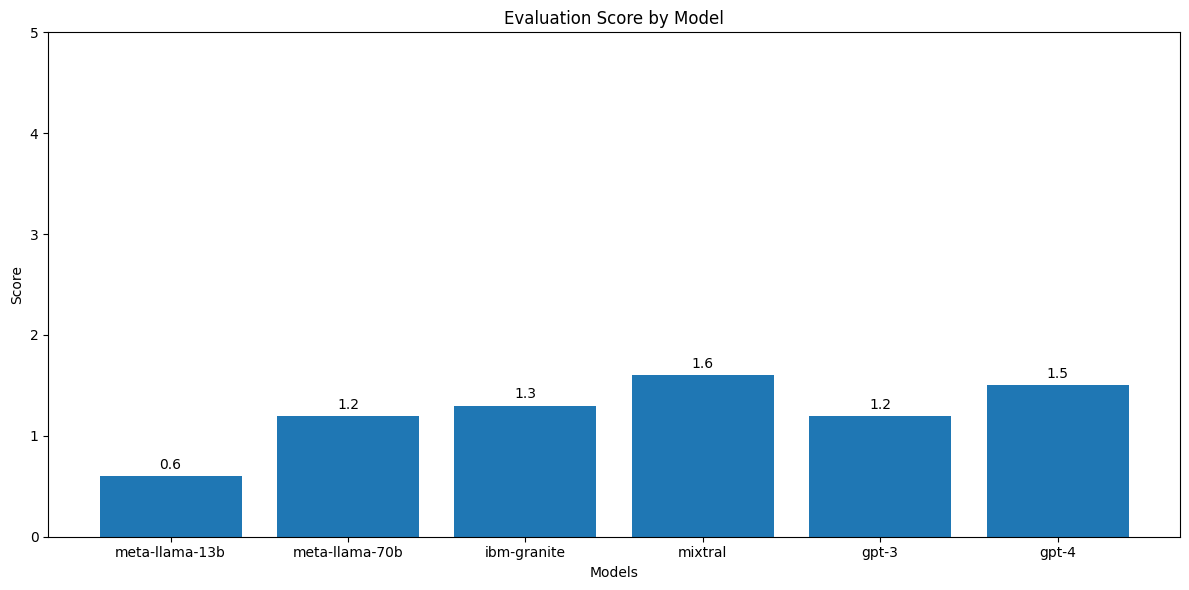

* meta-llama-13b
	1. (0/5) The original issue was not fixed. The import statement for javax.enterprise was not replaced with jakarta.enterprise as requested. Instead, it was removed entirely and a javax.enterprise.context.RequestScoped annotation was added, which does not address the migration to Quarkus.
	2. (2/5) The updated file has some syntactical issues. It imports many unnecessary Jandex-related classes that are not used in the code. The Serializable interface is used but not imported. The @Dependent annotation is still present but its import is missing. These issues may cause compilation errors.
* meta-llama-70b
	1. (0/5) The original issue of replacing the javax.enterprise import with jakarta.enterprise was not addressed. Instead, the import statement and @Dependent annotation were completely removed, which does not match the expected fix.
	2. (4/5) The updated file is syntactically valid and can be compiled. All classes and interfaces used are valid. The original functionalit

In [37]:

plot_chart_and_print_reasoning(zero_shot_easy_eval_output)

If you look at the reasoning our evaluation model produced for each output, and compare that with the actual generated file, we can see that the scores rightly (somewhat) reflect the idea of "accuracy" of a certain fix. One thing to note here is that since there is only one issue, the evaluation output is going to be pretty much binary. This won't be the case with harder example ahead. Therefore, comparing evaluation of easy example with the hard isn't much helpful.

> Note that absolute rating numbers don't matter much. We are more interested in looking at how a model does relatively in different scenarios. Finally, we will be looking at the trend of how things improved as Kai added more and more contextual information to the prompt.

### Hard example (Zero Shot)

Now we will run the same experiment with a harder example. The fix for this file involves more than just changing an import.

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_hard/` directory for each model.

In [11]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_hard", "./templates/zero_shot/default.jinja", EXAMPLE_HARD)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-4


Now we will run the evaluation.

In [75]:
zero_shot_hard_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/zero_shot_hard")

Now we plot the chart.

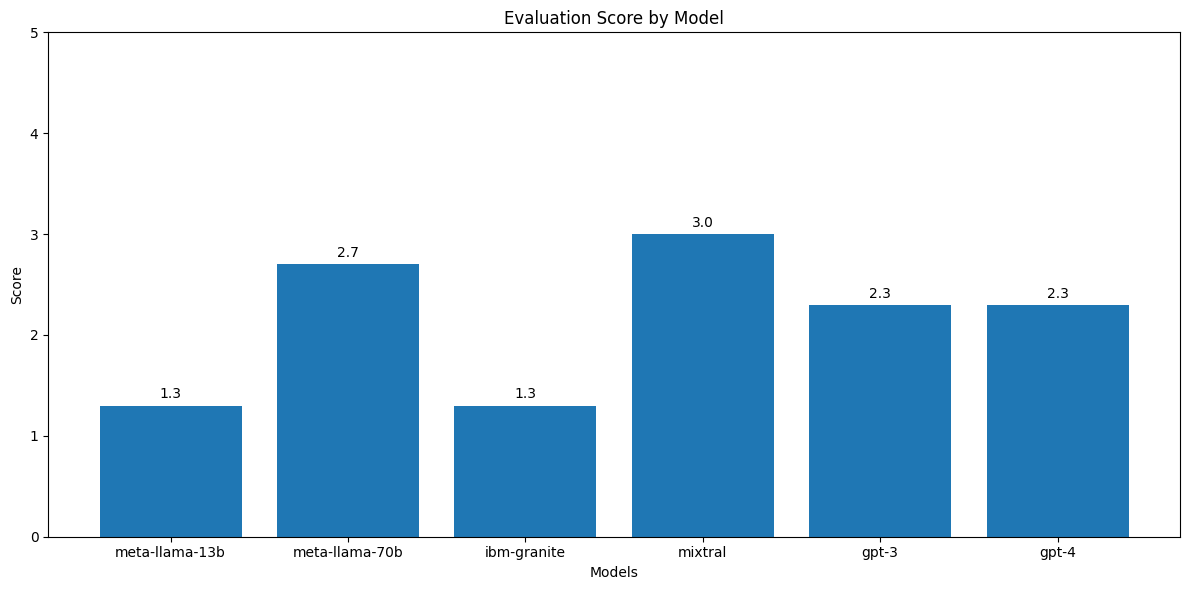

* meta-llama-13b
	1. (1/5) The updated file only fixes one issue (changing @Inject to @JmsContext for JMSContext), leaving most issues unresolved.
	2. (2/5) The updated file has syntactical issues, missing imports, and incorrect annotations, which would prevent compilation and potentially alter functionality.
* meta-llama-70b
	1. (3/5) While some issues were addressed, several remain unresolved, and new issues were introduced.
	2. (2/5) The updated file has syntactical issues and incorrect imports, which may prevent compilation and alter functionality.
* ibm-granite
	1. (1/5) The updated file does not fix any of the identified issues as described in the original issues list.
	2. (2/5) The updated file introduces several new issues, including incorrect imports, use of non-existent classes, and changes to the original functionality.
* mixtral
	1. (3/5) The updated file fixes some of the identified issues, but not all. It replaces @Stateless with @ApplicationScoped and replaces JMS Topic 

In [76]:
plot_chart_and_print_reasoning(zero_shot_hard_eval_output)

# Few Shot (Diff Only)

In this section, we will run the same examples but this time we will include solved examples in our prompts. 

We will start by including diff-only mode which includes diffs of solved examples in the input prompt directly.

## Easy example (Few Shot with Solved Examples Diff)

For the easy example we are using, solved solutions data is not available in Kai at the time of writing this. Therefore, we create our own example to use that contains a diff of an already solved incident. The prompt we use is [here](./templates/few_shot/easy_hardcoded.jinja)

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_easy/` directory for each model.

In [15]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_easy", "./templates/few_shot/easy_hardcoded.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_easy/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_easy/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/few_shot_easy/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/few_shot_easy/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/few_shot_easy/gpt-4


Now we will evaluate the responses.

In [65]:
few_shot_easy_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/few_shot_easy")

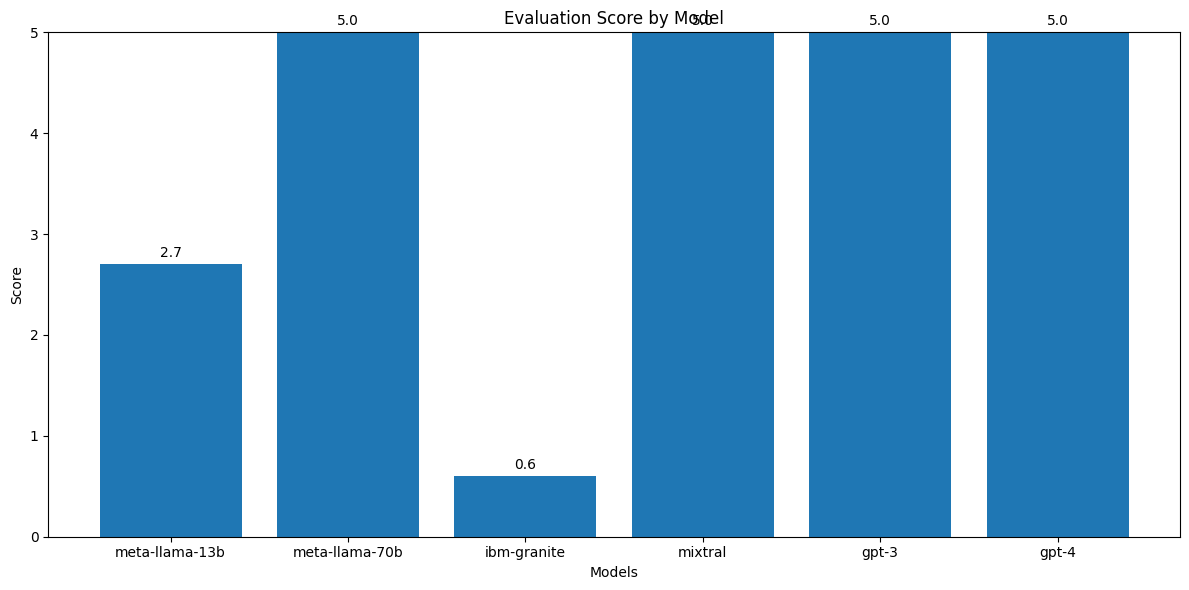

* meta-llama-13b
	1. (3/5) The issue of replacing the import statement has been fixed, but there are other general syntactical issues that have been introduced.
	2. (2/5) The updated file has fixed the import statement as requested, but it has removed other necessary imports and most of the class implementation, which would cause compilation errors and change the original functionality.
* meta-llama-70b
	1. (5/5) The issue has been fixed exactly as described. The import statement on line 7 has been correctly changed from 'javax.enterprise.context.Dependent' to 'jakarta.enterprise.context.Dependent'.
	2. (5/5) The updated file is syntactically valid and can be compiled. All classes, interfaces, and annotations used in the file are valid and imported correctly. The fixes do not change the original functionality of the code. The overall structure and logic of the class remain intact.
* ibm-granite
	1. (0/5) The issue identified in the JavaEE file has not been fixed in the updated file. Th

In [66]:
plot_chart_and_print_reasoning(few_shot_easy_eval_output)

## Hard example (Few Shot with Solved Examples Diff)

Since this file contains many incidents, and most of these incidents have solved examples stored in Kai, we were hitting input limits when we used a prompt that contains solved examples for all of the incidents. Therefore, we are only going to use solved example for the most difficult issue in the file which is to change the JMS Topic to an emitter. This is the 7th incident. We will be using [this prompt](./templates/few_shot/default.jinja).

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_hard/` directory for each model.

In [20]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_hard", "./templates/few_shot/default.jinja", EXAMPLE_HARD)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/few_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/few_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/few_shot_hard/gpt-4


Now lets evaluate the responses we get from all models.

In [21]:
few_shot_hard_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/few_shot_hard")

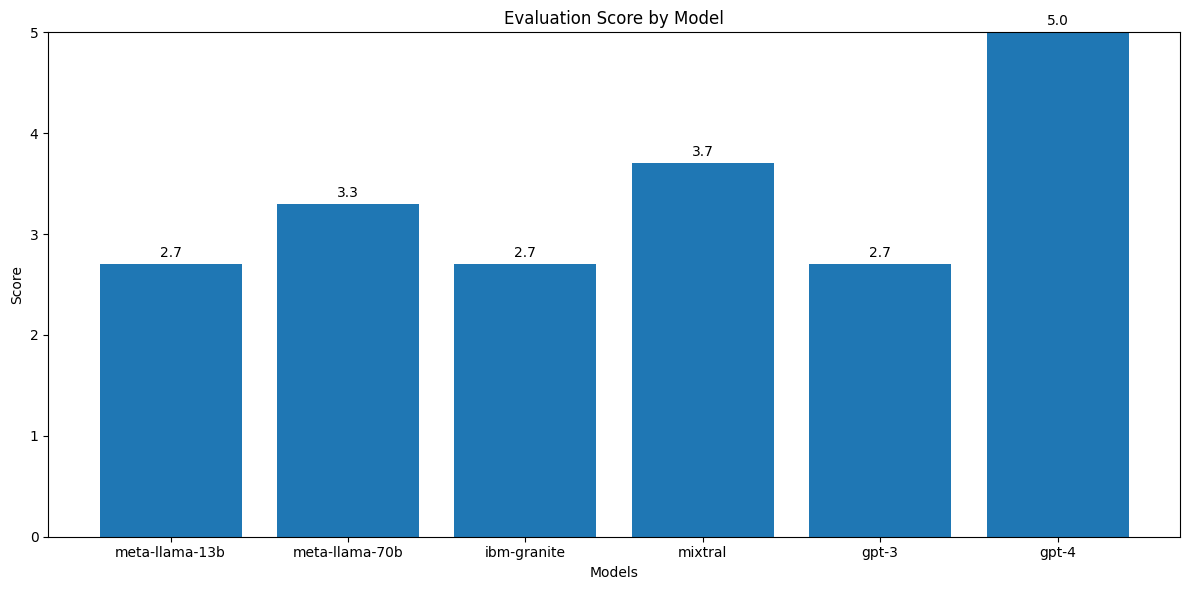

* meta-llama-13b
	1. (3/5) The file partially addresses the issues identified, but some remain unfixed and new issues are introduced.
	2. (2/5) The updated file has syntactical issues and missing imports, which may cause compilation errors.
* meta-llama-70b
	1. (3/5) The updated file fixes some of the issues but not all. It replaces some javax imports with jakarta, removes @Stateless, and replaces Topic with Emitter. However, it misses the @ApplicationScoped annotation and some jakarta imports.
	2. (4/5) The updated file is syntactically valid and can be compiled. Most classes and interfaces are imported correctly. The original functionality seems to be preserved. However, the missing @ApplicationScoped annotation might affect the bean's lifecycle.
* ibm-granite
	1. (3/5) The updated file partially addresses the issues identified in the JavaEE file, but it fails to implement some of the required changes and introduces new problems.
	2. (2/5) The updated file has several syntactical iss

In [22]:
plot_chart_and_print_reasoning(few_shot_hard_eval_output)

# Few Shot (LLM Summary)

In this section, we use a prompt that contains a summary of changes as solved examples. This summary will be generated by another LLM by looking at diffs of previous solved example. This differs from our last approach where we passed the diff directly to the LLM.

For examples we are using, solutions with summaries are not present in Kai at the time of creating this notebook. Therefore, we created these examples manually from diffs. We used the exact same prompt Kai uses to generate the LLM summary of solved examples.

For reference, find the summary generation prompts we used as well as generated summaries [here](./templates/summary_generation.jinja).

## Easy Example (Few Shot with Solved Examples Summary)

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_easy_llm_summary/` directory for each model.

We will be using a prompt we already created with LLM summary content [here](./templates/few_shot/easy_hardcoded_summary.jinja)

In [45]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_easy_llm_summary", "./templates/few_shot/easy_hardcoded_summary.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_easy_llm_summary/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/gpt-4


Now we evaluate the responses.

In [61]:
few_shot_easy_summary_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/few_shot_easy_llm_summary/")

Lets plot the chart now.

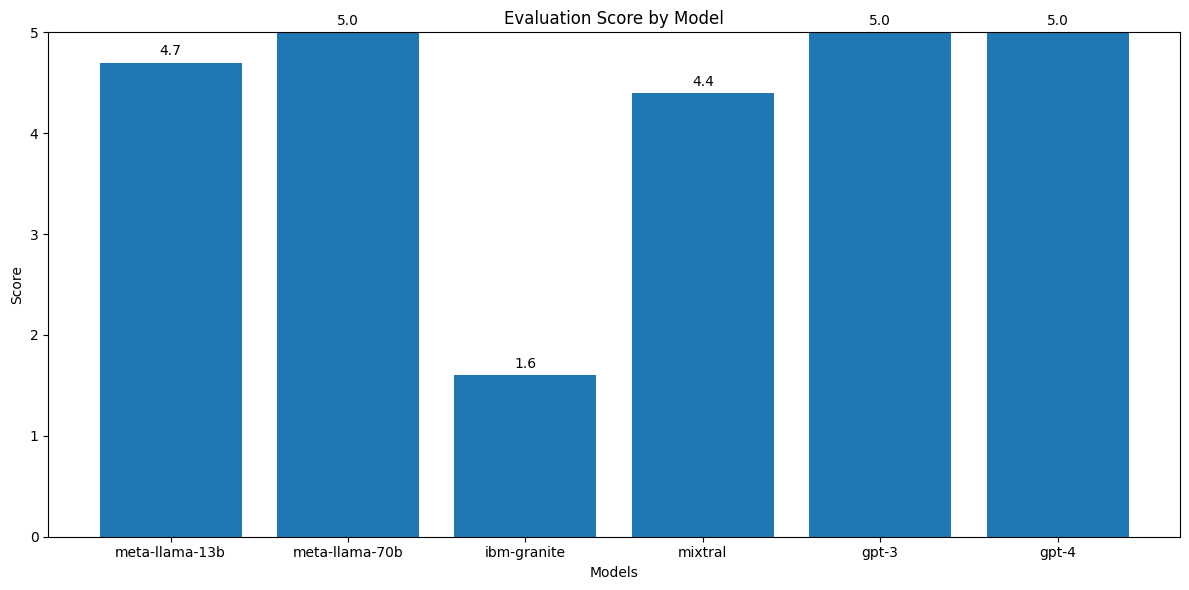

* meta-llama-13b
	1. (5/5) The issue of replacing the javax.enterprise import with jakarta.enterprise has been correctly fixed in the updated file.
	2. (4/5) The updated file is mostly syntactically valid, but there are a few minor issues: 1) The Serializable interface is not imported. 2) The ArrayList class is not imported. 3) Some fields and methods from the original file have been removed without clear reason. However, the core functionality appears to be maintained.
* meta-llama-70b
	1. (5/5) The issue has been correctly fixed by replacing the javax.enterprise import with jakarta.enterprise.
	2. (5/5) The updated file is syntactically valid, maintains the original functionality, and all necessary classes and annotations are correctly imported and used.
* ibm-granite
	1. (1/5) The issue of replacing the javax.enterprise import with jakarta.enterprise has been correctly fixed in the updated file.
	2. (3/5) While the specific issue has been addressed, the updated file only includes th

In [64]:
plot_chart_and_print_reasoning(few_shot_easy_summary_eval_output)

## Hard Example (Few Shot with Solved Examples Summary)

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_hard_llm_summary/` directory for each model.

We will be using a prompt we already created with LLM summary content [here](./templates/few_shot/hard_hardcoded_summary.jinja)

In [31]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_hard_llm_summary", "./templates/few_shot/hard_hardcoded_summary.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_hard_llm_summary/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/few_shot_hard_llm_summary/gpt-4


Now we run evaluation.

In [68]:
few_shot_hard_summary_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/few_shot_hard_llm_summary/")

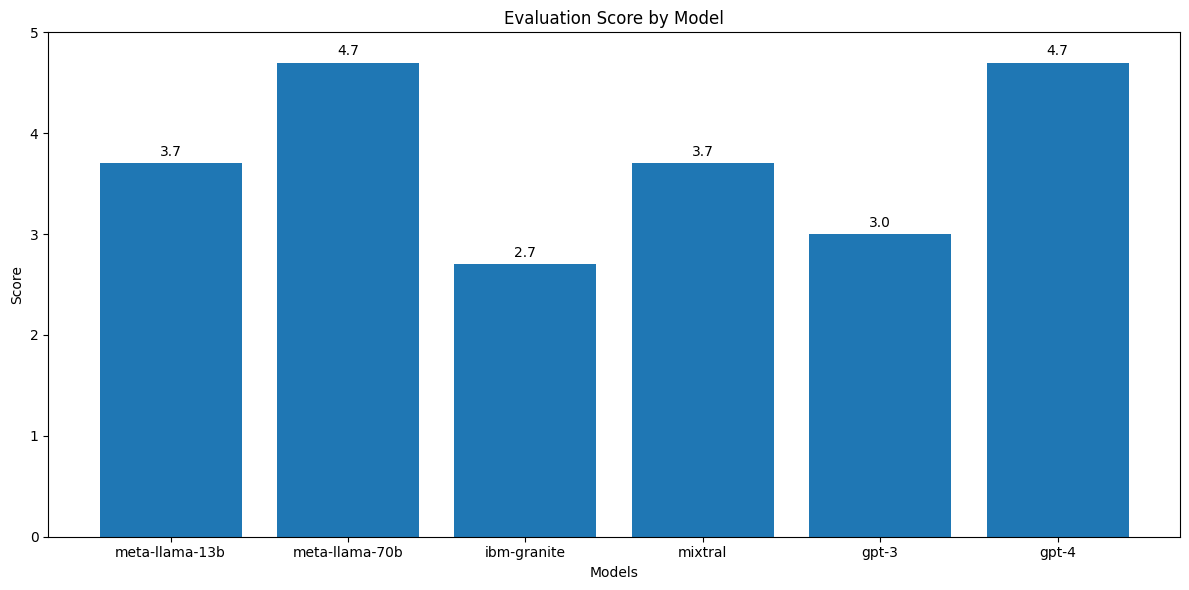

* meta-llama-13b
	1. (4/5) Most issues have been fixed correctly, but there are a couple of discrepancies. The `@Stateless` annotation was replaced with `@Singleton` instead of `@ApplicationScoped` as suggested, and the `JMSContext` was removed without replacement.
	2. (3/5) The file is mostly syntactically valid, but there are a few minor issues. The `Logger` import is missing, and the `@Resource` annotation is still used for the `Topic`, which should be removed if using an `Emitter`.
* meta-llama-70b
	1. (5/5) All issues have been correctly addressed in the updated file according to the provided descriptions.
	2. (4/5) The updated file appears to be syntactically valid and can be compiled. The necessary classes and interfaces are imported correctly. However, the `@Resource` annotation is imported but not used in the updated file, which is a minor issue.
* ibm-granite
	1. (3/5) Some issues are fixed, but not all. The import statements have been updated correctly, but the `@Stateless` 

In [69]:
plot_chart_and_print_reasoning(few_shot_hard_summary_eval_output)

# Comparing evaluation outputs for different scenarios

In this section, we compare evaluation outputs we obtained from various different scenarios in previous sections. 

## Easy Example

For the easy example, we looked at doing a simple fix with Kai which involved updating a single import statement.

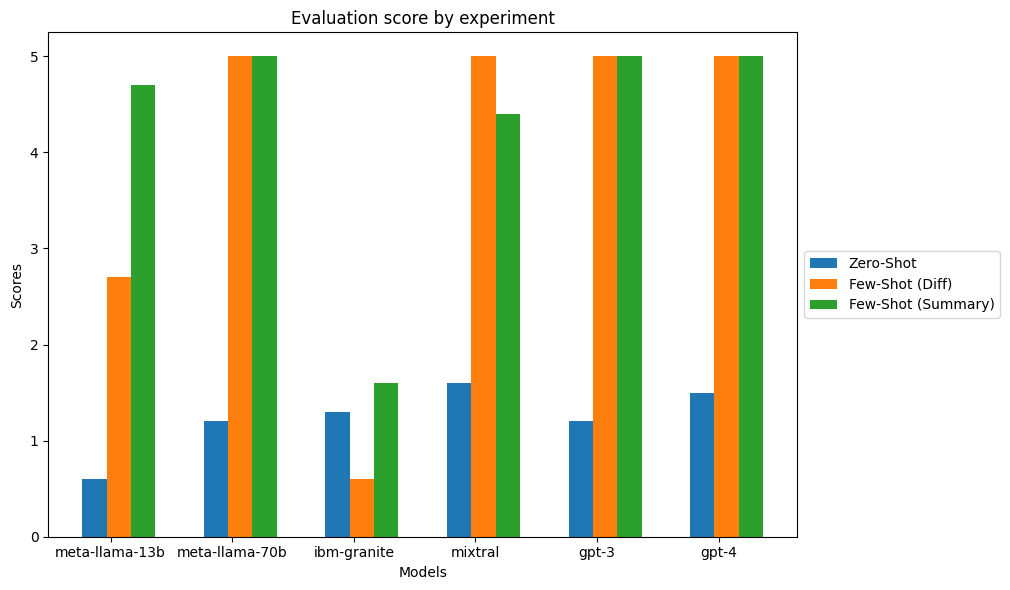

In [82]:
plot_multibar_chart_from_eval_outputs([
    (zero_shot_easy_eval_output, "Zero-Shot"), 
    (few_shot_easy_eval_output, "Few-Shot (Diff)"),
    (few_shot_easy_summary_eval_output, "Few-Shot (Summary)")])

## Hard Example


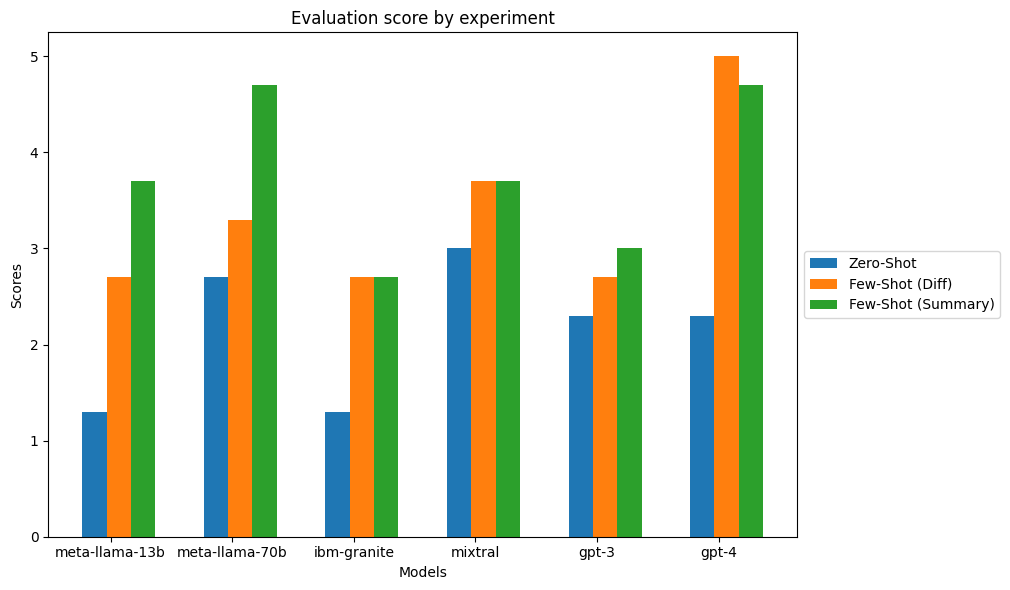

In [81]:

plot_multibar_chart_from_eval_outputs([
    (zero_shot_hard_eval_output, "Zero-Shot"), 
    (few_shot_hard_eval_output, "Few-Shot (Diff)"),
    (few_shot_hard_summary_eval_output, "Few-Shot (Summary)")
    ]) 

## Learnings

### About models

  * IBM Granite is very unpredictable, and we could not reliably determine the effect of adding analysis information on the quality of responses with it. It was hard to determine a pattern and correlate information.

  * Meta LLAMA 70b seemed to be performing more consistently (in all experiments) than others with relatively good quality of fixes.

  * GPT-4 performed better than others in Zero Shot experiments. However, it seemed to be fixing more than necessary, at times introducing new issues.

  * GPT-3 and LLAMA 13b have been comparable in terms of quality of fixes. On ther other hand, LLAMA 70b and GPT-4 are comparable.

  * Mixtral very often had problems returning a complete response, formatting etc. As a result, in some instances, we had to run an experiment multiple times to get results.

### Zero Shot Prompts

  * Zero Shot prompts work as long as the underlying model is trained with code for target technology. No matter the model, the accuracy of fixes degrades as files become larger, and/or fixes become more complex. 

  * Without any additional information from static code analysis, it was harder to get quality responses. Merely including line numbers of the incidents in the prompt did not help much. A text description about an issue that hints about a possible solution produced way better responses than line numbers alone. We believe that annotating input file with line numbers will produce a better output.

  * Zero Shot prompts may fix your issue but chances of them introducing new issues is higher because the issues are not pinpointed.

### Few Shot with Solved Example Diffs

  * Prompts that contain diffs of actual solved examples produce much better results than any of the previous methods. You can observe this in the evaluation charts above. No matter how smart / not-smart the underlying model, the results improved with this strategy than Zero Shot approach. 
  
  * However, there are limitations to this approach. We observed two main problems with this approach:
    
    1. With a big enough input file with multiple issues, prompts cross the input limits of most models. This is a blocking problem for Kai as it ends up not creating a response at all.
    
    2. The quality of response depends a lot on the quality of diff. A very pinpointed specific diff works better than a diff that contains lines that span more than just the issue in question. In fact, a larger diff with too many unrelated lines can hurt more than it helps. In order for this strategy to be helpful, Kai needs to pick the right examples. There needs to be some pre-processing on the diffs that makes sure only specific lines are saved.

  * Notice that for the easy example, the diff we included is a very specific diff that only contains two lines that are relevant to the issue.

  * For the hard example, we did use a diff from Kai's default data. However, we could not include diffs for all 10 issues in the file because of input limits. We only included one diff for the hardest fix in the file. Therefore, we will see worse performance with Kai as of today with this approach for larger files.

### Few Shot with Solved Example Summary

  * In most of the experiments we did, this proved to be the most successful method for ensuring a high quality response. For some models, we did see instances of diff performing better. The drop we saw wasn't because of a huge problem though.  

  * The main reason behind this being successful we think is that this addresses all problems / shortcomings of previous methods:
    1. The prompts contain pinpointed information unlike Zero-Shot
    2. With this approach, the prompts are significantly smaller and do not contain much out-of-scope information.

  * Like diff-only, the quality of responses highly depend on the quality of summary generated. At the time of writing this notebook, Kai generates summary of each incident. However, our experience running these experiments makes us believe that such a naive way of generating summary won't work reliably. Kai should employ more logic to combine multiple incidents together in a file and produce a summary by considering all of the issues, not just one.

### About evaluation
  
  * Evaluating code with LLMs is possible. We need to improve on evaluation. The evaluator can be given supplemental information about the updated file to improve the accuracy of evaluation score. The two main pieces of information include:
     * Whether the issue was fixed - we can run static code analysis again to provide this piece of information
     * Syntactical issues - a simple linter should be enough

  * "Evaluator persona" can be further used to feed information back into Kai fix to get even better results.

# Conclusion

Zero Shot prompts may work for modernizing small, somewhat easy and isolated examples of source code. The model needs to understand the target technology to produce useful results. However, when larger / complex codebases are involved, we observe that a smart model alone cannot help. We find that it's essential to pinpoint LLM to specific areas of codebase, and provide additional specific information about the issues to produce high quality responses.

Our results suggest that the approaches Kai is using to pinpoint issues using analysis information and solved examples improve the quality of responses. That being said, we also identify some problems with the current implementation of these approaches. We think that Kai must improve in following areas:

Relevancy of solved examples: In the solved example diffs, do not include lines that may confuse the LLM.
Fixes in the context of whole file: In the solved example summaries, try to provide summary by combining multiple incidents together in a file so it's shorter and takes into account effect of fixes affecting other issues in the file.
We believe that a mix of both diff and summary approaches might be better. More experimentation is needed to figure out how exactly that mix will look like.